This notebook uses Gaussian processes to find the distribution of functions that fit a toy dataset, both incorporating correlations between data points and treating each as independent. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigvals
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from GP import GaussianProcessRegressor

Define some toy data combining multiple perfectly correlated datasets with overlapping energy ranges. x denotes the measured values at each energy, each with some error bar. Each data point has 10% total error. There must be a relatively large number of data points to get a degenerate covariance matrix after the kernel is added -- this is a minimal example of such a dataset. 

In [ ]:
datasets = 3
n = 5
N = datasets*n                  # Total number of data points
percent_error = 0.1
x_sets = []                     # x for each dataset
y_sets = []                     # y for each dataset

x = np.zeros(N)                 # All x
y = np.zeros(N)                # All y

total_errors = np.zeros(N)
systematic_errors = np.zeros(N)
dataset_sizes = np.zeros(datasets)
for i in range(datasets):
    energies = np.array([j+1 for j in range(n)]) + (0.5-np.random.rand(n))
    values = 0.5-np.random.rand(n) + energies                # Provides overall linear relationship with correlated noise
    x_sets.append(energies)
    y_sets.append(values)
    
    s = percent_error*np.abs(values)
    
    for j in range(n):
        index = i*n+j
        x[index] = energies[j]
        y[index] = values[j]
        total_errors[index] = s[j] 
        systematic_errors[index] = s[j] 
    dataset_sizes[i] = n


NameError: name 'np' is not defined

In [2]:
# Plot the toy data

for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.', label=f'{i+1}')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(f'Toy Data, {datasets} datasets')
plt.show()
plt.clf()

NameError: name 'plt' is not defined

An adapted Gaussian process regression code from scikit-learn that incorporates degeneracies amongst the data is used.

In [4]:
magnitude = 1                             # Initial values for kernel hyperparameters, which get set by extremizing the log-likelihood
length_scale = 1
kernel = ConstantKernel(magnitude) * RBF(length_scale) 
correlated_gp = GaussianProcessRegressor(kernel=kernel)
uncorrelated_gp = GaussianProcessRegressor(kernel=kernel)

correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
uncorrelated_gp, uncorrelated_K11 = uncorrelated_gp.fit(x.reshape(-1,1), y, total=total_errors)

/Users/timlaunders/miniconda3/envs/linx/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/timlaunders/miniconda3/envs/linx/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


While the uncorrelated case produces one large eigenvalue with the rest around 0.1-0.01, the correlated case has an effective rank much lower than the number of columns. (This includes )

In [5]:
lower_bound = 1e-5

uncorrelated_eigvals = eigvals(uncorrelated_K11)
print('Uncorrelated GP upper left covariance eigenvalues:\n', uncorrelated_eigvals)
print('Effective rank: ', np.sum(uncorrelated_eigvals > lower_bound))

correlated_eigvals = eigvals(correlated_K11)
print('\nCorrelated GP upper left covariance eigenvalues:\n', correlated_eigvals)
print('Effective rank: ', np.sum(correlated_eigvals > lower_bound))

Uncorrelated GP upper left covariance eigenvalues:
 [2.65763013e+02+0.j 1.91157256e+01+0.j 7.01592003e-01+0.j
 2.91182200e-01+0.j 2.63894665e-01+0.j 2.10201377e-02+0.j
 7.46082751e-03+0.j 1.09017057e-02+0.j 1.19852499e-02+0.j
 6.10752835e-02+0.j 1.42392978e-01+0.j 1.34546434e-01+0.j
 8.55787598e-02+0.j 1.01237671e-01+0.j 1.13772171e-01+0.j]
Effective rank:  15

Correlated GP upper left covariance eigenvalues:
 [6.53234278e-01+0.00000000e+00j 5.26548898e-01+0.00000000e+00j
 4.67236865e-01+0.00000000e+00j 3.44566334e-05+0.00000000e+00j
 9.99998367e-11+0.00000000e+00j 1.00000375e-10+0.00000000e+00j
 9.99999734e-11+0.00000000e+00j 1.00000022e-10+0.00000000e+00j
 9.99999861e-11+6.65901410e-18j 9.99999861e-11-6.65901410e-18j
 1.00000002e-10+4.40717228e-18j 1.00000002e-10-4.40717228e-18j
 1.00000005e-10+0.00000000e+00j 1.00000002e-10+0.00000000e+00j
 9.99999992e-11+0.00000000e+00j]
Effective rank:  4


In [6]:
# Get GP posterior

num_test = 300
x_test = np.linspace(0.5, n+0.5, num_test)
correlated_mean, correlated_std = correlated_gp.predict(x_test.reshape(-1,1), return_std=True)
uncorrelated_mean, uncorrelated_std = uncorrelated_gp.predict(x_test.reshape(-1,1), return_std=True)

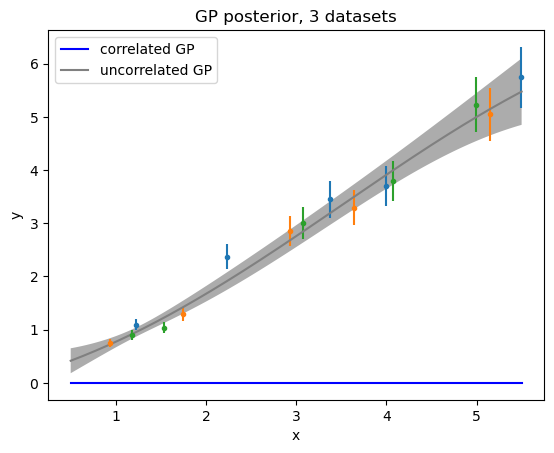

In [7]:
# Plot both posteriors

for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.')

plt.plot(x_test, correlated_mean, color='blue', label='correlated GP')
plt.fill_between(x_test, correlated_mean - 2*correlated_std, correlated_mean + 2*correlated_std, color='blue', alpha=0.65, edgecolor='none')
plt.plot(x_test, uncorrelated_mean, color='grey', label='uncorrelated GP')
plt.fill_between(x_test, uncorrelated_mean - 2*uncorrelated_std, uncorrelated_mean + 2*uncorrelated_std, color='grey', alpha=0.65, edgecolor='none')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(f'GP posterior, {datasets} datasets')
plt.show()

This analysis is repeated with only 1 correlated dataset.

In [8]:
x = np.zeros(n)
y = np.zeros(n)
total_errors = np.zeros(n)
systematic_errors = np.zeros(n)
dataset_sizes = np.zeros(datasets)

energies = np.array([j+1 for j in range(n)]) + (0.5-np.random.rand(n))
values = 0.5-np.random.rand(n) + energies

s = percent_error*np.abs(values)

for j in range(n):
    x[j] = energies[j]
    y[j] = values[j]
    total_errors[j] = s[j] 
    systematic_errors[j] = s[j]
dataset_sizes[i] = n

In [9]:
correlated_gp = GaussianProcessRegressor(kernel=kernel)
uncorrelated_gp = GaussianProcessRegressor(kernel=kernel)

correlated_gp, correlated_K11 = correlated_gp.fit(x.reshape(-1,1), y, total=total_errors, norms=systematic_errors, points=dataset_sizes)
uncorrelated_gp, uncorrelated_K11 = uncorrelated_gp.fit(x.reshape(-1,1), y, total=total_errors)

correlated_mean, correlated_std = correlated_gp.predict(x_test.reshape(-1,1), return_std=True)
uncorrelated_mean, uncorrelated_std = uncorrelated_gp.predict(x_test.reshape(-1,1), return_std=True)

In [10]:
print('Uncorrelated GP upper left covariance eigenvalues:\n', eigvals(uncorrelated_K11))
print('\nCorrelated GP upper left covariacnce eigenvalues:\n', eigvals(correlated_K11))

Uncorrelated GP upper left covariance eigenvalues:
 [1.29549012e+02+0.j 6.34282864e+00+0.j 2.74252929e-01+0.j
 4.86934964e-02+0.j 1.03192919e-01+0.j]

Correlated GP upper left covariacnce eigenvalues:
 [32.79974644+0.j 12.444628  +0.j  7.03587612+0.j  1.3191344 +0.j
  0.03759585+0.j]


The effect is not as pronounced as before (note the eigenvalues have not decayed to near 0 with only 5 total data points). However, the correlated case still shows a mean driven below the input data points. Note that since 10% total error is used, the smallest data point has the smallest error.

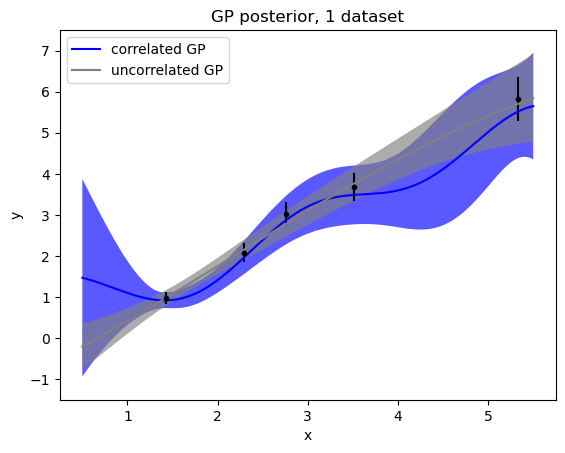

In [11]:
plt.errorbar(x, y, percent_error*np.abs(x), fmt='.', color='black')

plt.plot(x_test, correlated_mean, color='blue', label='correlated GP')
plt.fill_between(x_test, correlated_mean - 2*correlated_std, correlated_mean + 2*correlated_std, color='blue', alpha=0.65, edgecolor='none')
plt.plot(x_test, uncorrelated_mean, color='grey', label='uncorrelated GP')
plt.fill_between(x_test, uncorrelated_mean - 2*uncorrelated_std, uncorrelated_mean + 2*uncorrelated_std, color='grey', alpha=0.65, edgecolor='none')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.ylim(-1.5,7.5)
plt.title('GP posterior, 1 dataset')
plt.show()

This posterior is clearly not a reasonable fit to these data points -- away from measured points, the conditional mean is driven to the prior mean of the Gaussian process. To produce a reasonable fit in the correlated case, the mean prior can be set to the uncorrelated mean, with adjustments to the conditional mean given by the correlations. 

In [12]:
def mean_func(target_x):
    return uncorrelated_gp.predict(np.array([[target_x]]).reshape(-1,1))

nonzero_gp = GaussianProcessRegressor(kernel)
nonzero_gp, nonzero_K11 = nonzero_gp.fit(x.reshape(-1,1), y, mean_func, total_errors, systematic_errors, dataset_sizes)

nonzero_mean, nonzero_std = nonzero_gp.predict(x_test.reshape(-1,1), return_std=True)


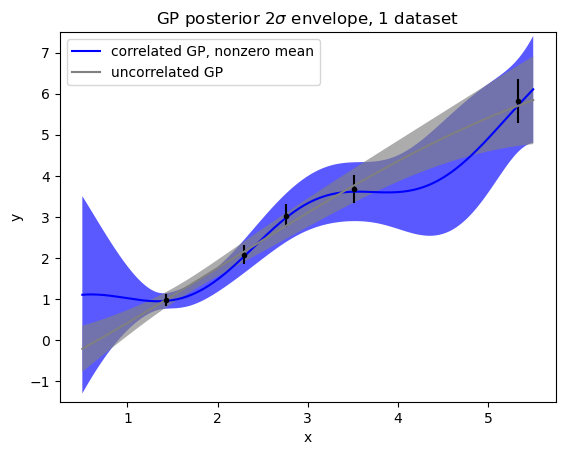

In [13]:
plt.errorbar(x, y, percent_error*np.abs(x), fmt='.', color='black')

plt.plot(x_test, nonzero_mean, color='blue', label='correlated GP, nonzero mean')
plt.fill_between(x_test, nonzero_mean - 2*nonzero_std, nonzero_mean + 2*nonzero_std, color='blue', alpha=0.65, edgecolor='none')
plt.plot(x_test, uncorrelated_mean, color='grey', label='uncorrelated GP')
plt.fill_between(x_test, uncorrelated_mean - 2*uncorrelated_std, uncorrelated_mean + 2*uncorrelated_std, color='grey', alpha=0.65, edgecolor='none')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.ylim(-1.5,7.5)
plt.title(r'GP posterior 2$\sigma$ envelope, 1 dataset')
plt.show()

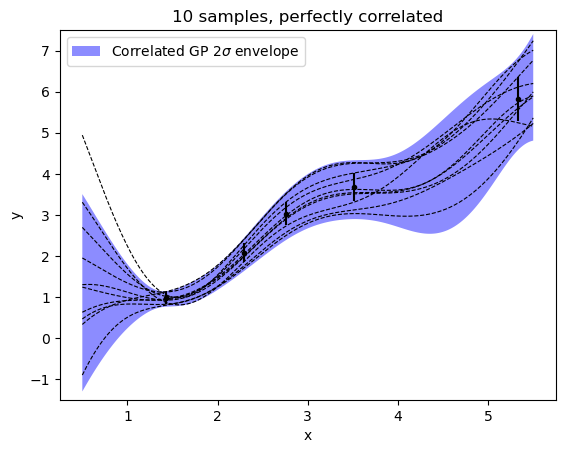

In [14]:
# Draw samples from this posterior

num_samples = 10
samples = nonzero_gp.sample_y(x_test.reshape(-1,1), num_samples)
plt.errorbar(x, y, percent_error*np.abs(x), fmt='.', color='black')
plt.fill_between(x_test, nonzero_mean - 2*nonzero_std, nonzero_mean + 2*nonzero_std, color='blue', alpha=0.45, edgecolor='none', label=r'Correlated GP 2$\sigma$ envelope')
plt.plot(x_test, samples, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.ylim(-1.5,7.5)
plt.title(f'{num_samples} samples, perfectly correlated')
plt.show()

In between the first and last data point, the samples all have the same shape with different normalizations, as expected for data points which are perfectly correlated. Additionally, the mean passes right through each data point, as expected. This differs from the uncorrelated case.

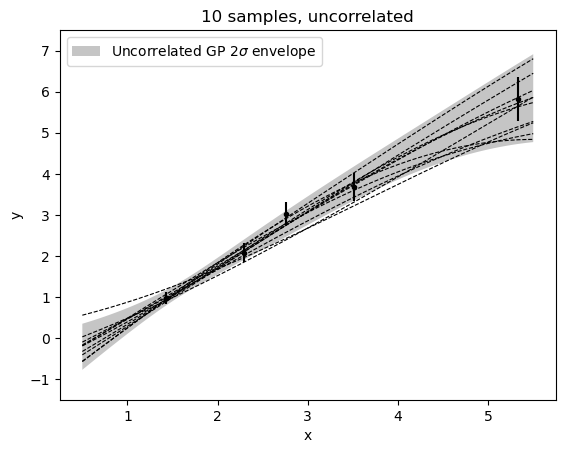

In [15]:
num_samples = 10
samples = uncorrelated_gp.sample_y(x_test.reshape(-1,1), num_samples)
plt.errorbar(x, y, percent_error*np.abs(x), fmt='.', color='black')
plt.fill_between(x_test, uncorrelated_mean - 2*uncorrelated_std, uncorrelated_mean + 2*uncorrelated_std, color='grey', alpha=0.45, edgecolor='none', label=r'Uncorrelated GP 2$\sigma$ envelope')
plt.plot(x_test, samples, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.ylim(-1.5,7.5)
plt.title(f'{num_samples} samples, uncorrelated')
plt.show()

This does not fix the issue with in the 3 dataset case presented first, as that covariance matrix effectively remains degenerate even with the kernel and a different handling is required. 